## Perturbation of sequences
### Dataset: WIV04 
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [12]:
human_label = "Human"
perturbation_processed_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/WIV04/cov-S-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed/tl_tf_binary_wiv04_s_prot.csv")

In [7]:
perturbed_output_df = pd.read_csv(perturbation_processed_output_file_path)
print(perturbed_output_df.shape)

(31826, 7)


In [8]:
perturbed_output_df.head()

,Human,Non-Human,id,y_true,orig_token,perturb_pos,new_token
0,0.996006,0.003994,WIV04,Human,G,592,R
1,0.996033,0.003967,WIV04,Human,I,804,B
2,0.996209,0.003791,WIV04,Human,D,39,R
3,0.995978,0.004022,WIV04,Human,K,128,R
4,0.996113,0.003887,WIV04,Human,Q,689,P


In [11]:
orig_seq_df = perturbed_output_df[perturbed_output_df["orig_token"] == perturbed_output_df["new_token"]]
orig_seq_df

,Human,Non-Human,id,y_true,orig_token,perturb_pos,new_token
5674,0.996061,0.003939,WIV04,Human,M,0,M


In [17]:
orig_seq_df_pred = orig_seq_df[human_label].values[0]
orig_seq_df_pred

0.9960609

In [21]:
pred_diff_col = f"{human_label}_pred_diff"
perturbed_output_df[pred_diff_col] = orig_seq_df_pred - perturbed_output_df[human_label]
perturbed_output_df.head()

,Human,Non-Human,id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff
0,0.996006,0.003994,WIV04,Human,G,592,R,0.000055
1,0.996033,0.003967,WIV04,Human,I,804,B,0.000028
2,0.996209,0.003791,WIV04,Human,D,39,R,-0.000148
3,0.995978,0.004022,WIV04,Human,K,128,R,0.000083
4,0.996113,0.003887,WIV04,Human,Q,689,P,-0.000052


In [22]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.003146,0.017927,31825,99.996858
1,0.017927,0.039000,0,0.000000
2,0.039000,0.060072,0,0.000000
3,0.060072,0.081145,0,0.000000
4,0.081145,0.102218,0,0.000000
5,0.102218,0.123291,0,0.000000
6,0.123291,0.144363,0,0.000000
7,0.144363,0.165436,0,0.000000
8,0.165436,0.186509,0,0.000000
9,0.186509,0.207582,0,0.000000


In [24]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values=pred_diff_col)
df

perturb_pos,0,1,2,3,4,5,6,7,8,9,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272
new_token,,,,,,,,,,,,,,,,,,,,,
A,-0.001658,0.001025,0.000091,0.000168,0.000144,0.000166,0.000192,0.000210,1.605700e-04,0.000243,...,4.100000e-06,0.000062,0.000057,0.000040,0.000023,0.000107,0.000080,3.210000e-05,2.765000e-05,2.777000e-05
B,-0.001752,0.000851,-0.000026,0.000046,-0.000011,-0.000011,-0.000002,-0.000005,1.000000e-07,0.000014,...,-3.917000e-05,0.000020,0.000009,-0.000017,-0.000039,0.000043,0.000019,-1.490000e-05,-9.960000e-06,-1.030000e-05
C,-0.001897,0.000740,-0.000055,0.000015,-0.000043,-0.000032,-0.000033,-0.000036,-2.737000e-05,-0.000029,...,-1.057500e-04,-0.000056,-0.000073,-0.000102,-0.000148,-0.000068,-0.000056,-8.155000e-05,-7.520000e-05,-4.865000e-05
D,-0.001718,0.000896,0.000002,0.000063,-0.000007,0.000004,0.000006,0.000003,3.653000e-05,0.000034,...,-1.172500e-04,-0.000001,-0.000034,-0.000051,-0.000065,-0.000007,-0.000023,-5.610000e-05,-4.435000e-05,-4.110000e-05
E,-0.001597,0.001003,0.000093,0.000145,0.000080,0.000077,0.000053,0.000041,7.044000e-05,0.000107,...,-3.480000e-05,0.000032,0.000017,-0.000009,-0.000022,0.000041,0.000015,-1.354000e-05,-2.630000e-06,-9.700000e-06
F,-0.002631,NaN,-0.000115,NaN,-0.000028,0.000005,0.000014,-0.000002,9.500000e-07,0.000000,...,4.726000e-05,0.000082,0.000073,0.000057,0.000018,0.000094,0.000089,5.250000e-05,3.343000e-05,4.005000e-05
G,-0.001677,0.000884,-0.000020,0.000064,0.000059,0.000096,0.000119,0.000107,2.100000e-06,0.000093,...,-8.530000e-06,0.000044,0.000028,NaN,-0.000011,0.000064,0.000043,2.300000e-07,1.430000e-05,5.650000e-06
H,-0.001676,0.001072,0.000234,0.000361,0.000300,0.000277,0.000257,0.000202,2.107000e-04,0.000313,...,1.120000e-05,0.000063,0.000061,0.000019,0.000013,0.000078,0.000048,NaN,1.550000e-05,1.550000e-05
I,-0.001785,0.000784,-0.000081,-0.000008,-0.000066,-0.000075,-0.000075,-0.000088,-1.228000e-04,-0.000088,...,-3.700000e-05,0.000017,0.000007,-0.000018,-0.000051,0.000044,0.000016,-3.800000e-06,-9.600000e-06,-1.030000e-05


In [29]:
df[[371, 372, 613, 614, 615]]

perturb_pos,371,372,613,614,615
new_token,,,,,
A,NaN,0.000105,0.000088,0.000091,0.000187
B,-0.000084,0.000016,-0.000022,-0.000017,0.000075
C,-0.000141,-0.000044,-0.000104,-0.000132,-0.000042
D,-0.000049,0.000042,NaN,0.000023,0.000097
E,-0.000040,0.000051,0.000015,0.000043,0.000119
F,-0.000092,0.000023,-0.000039,-0.000031,0.000080
G,-0.000066,0.000035,-0.000025,-0.000008,0.000084
H,-0.000064,0.000045,0.000020,0.000026,0.000117
I,-0.000111,0.000004,-0.000067,-0.000065,0.000036


<Figure size 432x288 with 0 Axes>

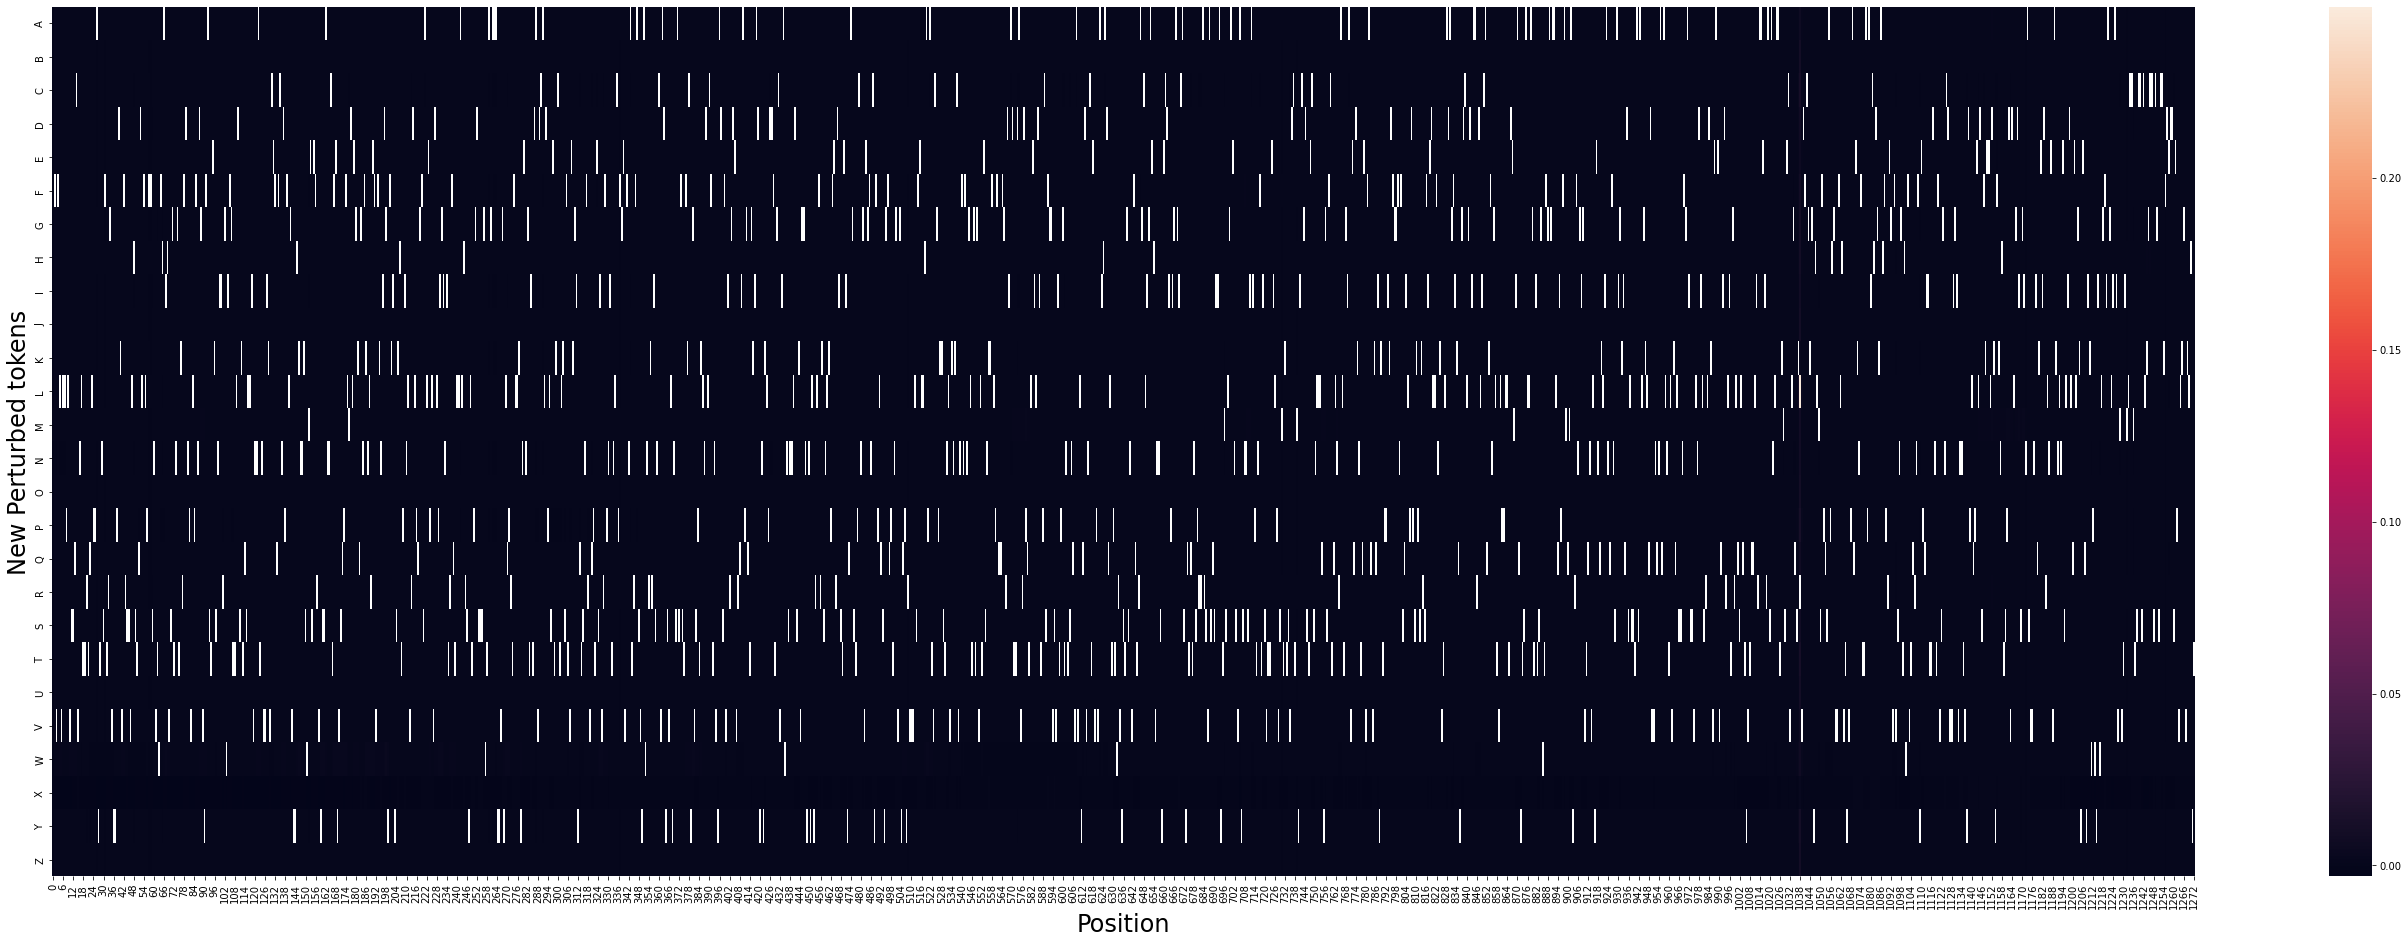

In [25]:
plt.clf()
plt.figure(figsize=(48, 16))
ax = sns.heatmap(df)
# plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.xlabel('Position', fontsize=24)
plt.ylabel('New Perturbed tokens', fontsize=24)
plt.show()

In [26]:
df.mean(axis=0)

perturb_pos
0      -0.001770
1       0.000773
2      -0.000095
3       0.000003
4      -0.000022
          ...   
1268    0.000016
1269    0.000005
1270   -0.000044
1271   -0.000024
1272   -0.000029
Length: 1273, dtype: float64

<Figure size 432x288 with 0 Axes>

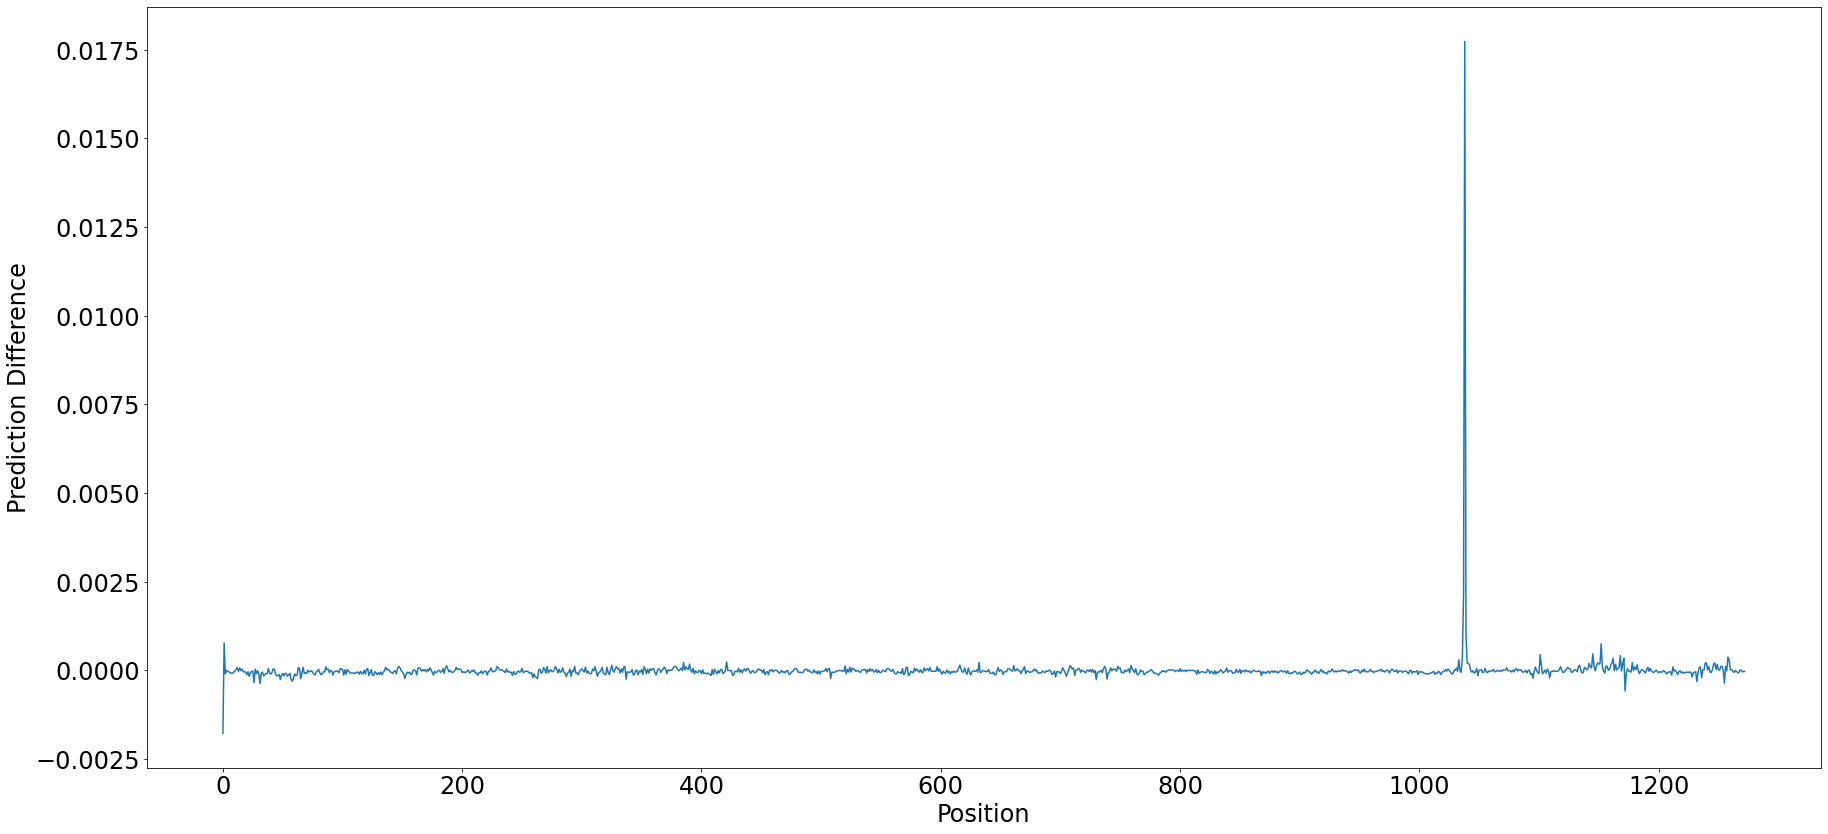

In [27]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
# ax.set_xlim(0, 1273)
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.xlabel('Position', fontsize=24)
plt.ylabel('Prediction Difference', fontsize=24)
plt.show()